In [1]:
import numpy as np
import pylab as plt
import glob
import h5py
import random

import sys
sys.path.insert(0,'../')
import cnn_rfi as crf


%matplotlib inline

In [2]:
sim_files = glob.glob('../data/*.h5')
#sim_files = [sys.argv[1]]
for i,filename in enumerate(sim_files):
    print i
    out_name = filename[:-3]

    with h5py.File(filename,"r") as fp: 
        data = fp['data'].value
        mask = fp['mask'].value
        freq = fp['frequencies'].value
        time = fp['time'].value
        ra = fp['ra'].value
        dec = fp['dec'].value
        ref_channel = fp['ref_channel'].value

    data = np.clip(np.fabs(data), 0, 200)


0
1
2
3
4
5
6
7
8
9


In [12]:
class data_provider(object):
    
    def __init__(self,files_list,nx,ny):
        self.filename = files_list
        self.nx = nx
        self.ny = ny
        
    def __call__(self,ns):     
        
        nx = self.nx
        ny = self.ny
        
        file_name= random.choice(files_list)

        with h5py.File(filename,"r") as fp: 
            data = fp['data'].value
            mask = fp['mask'].value
            freq = fp['frequencies'].value
            time = fp['time'].value
            ra = fp['ra'].value
            dec = fp['dec'].value
            ref_channel = fp['ref_channel'].value

        data = np.clip(np.fabs(data), 0, 200)
        data -= data.min()
        data /= data.max()

        lnx,lny = data.shape
        X = []
        Y = []
        for i in range(ns):
            y0 = np.random.randint(lny-ws)
            
            X.append(data[:,y0:y0+ny])
            Y.append(mask[:,y0:y0+ny])
    
        return np.array(X).reshape(ns,nx,ny,1),np.array(Y).reshape(ns,nx,ny,1)


In [13]:
files_list = glob.glob('../data/*.h5')
ws = 400
dp = data_provider(files_list,276,400)
dp(5)[0].shape

(5, 276, 400, 1)

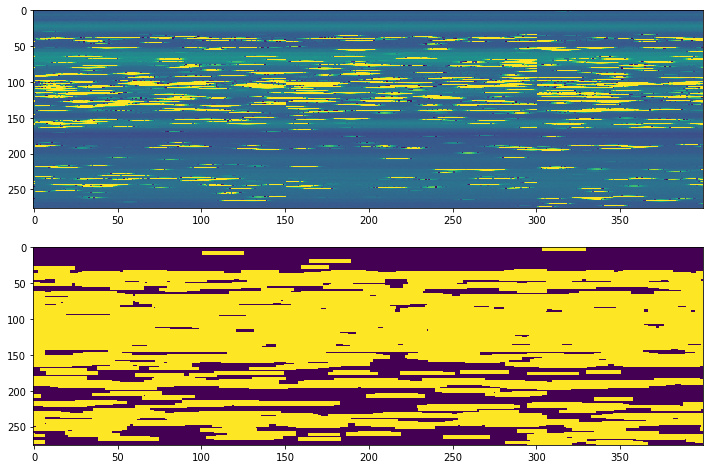

In [14]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
x,y = dp(5)
ax1.imshow(x[0,:,:,0],aspect='auto')
ax2.imshow(y[0,:,:,0],aspect='auto')

In [4]:
conv = crf.ConvolutionalLayers(nx=276,ny=400,learning_rate = 0.001,n_channel=1,restore=1,
                        model_add='./model',arch_file_name='arch')

INFO:tensorflow:Restoring parameters from ./model/model


In [16]:
conv.train(data_provider=dp,training_epochs = 5,n_s = 10, dropout=0.7, time_limit=None, verbose=1)

Epoch:0, cost= 153820.558594
Epoch:1, cost= 139945.926563
Epoch:2, cost= 138704.097656
Epoch:3, cost= 140907.093750
Epoch:4, cost= 133356.725000


In [18]:
with h5py.File('../data/TEST_MP_PXX_20160302_000000.h5',"r") as fp: 
    data = fp['data'].value
    mask = fp['mask'].value
    freq = fp['frequencies'].value
    time = fp['time'].value
    ra = fp['ra'].value
    dec = fp['dec'].value
    ref_channel = fp['ref_channel'].value
    
data = data[:,:2000]
pred = conv.conv_large_image(data.reshape(1,276,2000,1),pad=10,lx=276,ly=400)


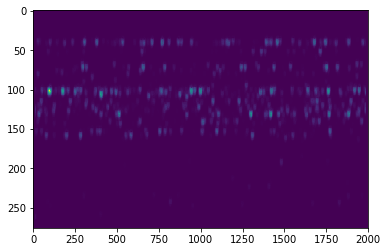

In [19]:
plt.imshow(pred[:,:],aspect='auto')